In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pipeline.utils import read_json, make_folder
from itertools import combinations
from sklearn.neighbors import KernelDensity
import prose.datainsights as di

In [2]:
def estimate_density(input_df, y_col, sensi_col, dense_cols, n_groups=2, n_labels=2,
                     dense_h=0.1, dense_kernal='gaussian', algorithm='auto'):
    res_df = input_df.copy()

    for group_i in range(n_groups):
        for c_i in range(n_labels):
            dense_col_name = '_'.join(['density', 'G' + str(group_i), 'L' + str(c_i)])
            dense_train = res_df[(res_df[sensi_col] == group_i) & (res_df[y_col] == c_i)].copy()
            dense_X = dense_train[dense_cols].to_numpy()
            kde = KernelDensity(bandwidth=dense_h, kernel=dense_kernal, algorithm=algorithm)
            kde.fit(dense_X)
            res_df[dense_col_name] = kde.score_samples(res_df[dense_cols].to_numpy())
    return res_df
def combine_dense(x):
    idx_map = {'00': 0, '01': 1, '10': 2, '11': 3}   
    cur = '{}{}'.format(int(x.iloc[0]), int(x.iloc[1]))
    return x.iloc[2+idx_map[cur]]
def get_maximum(x):
    return max(x)

In [3]:
df = pd.read_csv('data/processed/lsac.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,A
0,0.00,3.1,68,-1.79,30.0,625.789460,4,0.0,2,0.0,0,1
1,1.88,3.5,69,1.33,44.0,886.842082,5,0.0,4,0.0,1,1
2,-0.57,3.5,69,-0.11,29.0,649.999987,4,0.0,2,0.0,1,1
3,0.95,3.0,58,1.22,35.0,694.736825,5,0.0,3,1.0,0,1
4,0.00,2.9,51,0.88,39.0,747.894717,4,0.0,2,1.0,0,1


In [7]:
df_sample = df.sample(n=20000)

In [8]:
# dense_df = estimate_density(df, 'credit', 'age', ['month', 'credit_amount'])
# dense_df = estimate_density(df, 'Y', 'C0', ['X{}'.format(i) for i in range(1, 10)])
# dense_df.head()

In [18]:
dense_n = 2000
n_max_att = 9
for group_i in range(2):
        for label_i in range(2):
            di_train = df_sample[(df_sample['C0'] == group_i) & (df_sample['Y'] == label_i)].copy()
            
            max_atts = []
            for n_num_atts in range(1, n_max_att+1):
                cur_cols = ['X{}'.format(n_num_atts)]
                
                
                dense_X = di_train[cur_cols].to_numpy()
                kde = KernelDensity(bandwidth=0.1, kernel='tophat', algorithm='auto')
                kde.fit(dense_X)
                di_train['density'] = kde.score_samples(di_train[cur_cols].to_numpy())
                di_train.sort_values(by=['density'], ascending=False, inplace=True)

                
                cc_input = di_train.iloc[:dense_n, :].copy() # dense_n points with highest density score
                assertions_i = di.learn_assertions(cc_input[cur_cols], max_self_violation=1.0)

                result_i = assertions_i.evaluate(di_train[cur_cols], explanation=True, normalizeViolation=True)
                di_train['vio_{}'.format(n_num_atts)] = result_i.row_wise_violation_summary['violation']
                cc_vio = di_train['vio_{}'.format(n_num_atts)].mean()
                print(group_i, label_i, '-->',n_num_atts, cc_vio)
                max_atts.append(cc_vio)
            
            att_used = []
            for i, cc_vio in enumerate(max_atts):
                count_order = sum([int(cc_vio > x) for x in max_atts])
                if count_order > int(len(max_atts)//2):
                    att_used.append('X{}'.format(i+1))
            
            print(group_i, label_i, att_used, '\n')
            output = sum([list(map(list, combinations(att_used, i))) for i in range(len(att_used) + 1)], [])
            
            for cur_cols in output:
                if len(cur_cols) > 0:
                    
                    dense_X = di_train[cur_cols].to_numpy()
                    kde = KernelDensity(bandwidth=0.1, kernel='tophat', algorithm='auto')
                    kde.fit(dense_X)
                    di_train['density'] = kde.score_samples(di_train[cur_cols].to_numpy())
                    di_train.sort_values(by=['density'], ascending=False, inplace=True)


                    cc_input = di_train.iloc[:dense_n, :].copy() # dense_n points with highest density score
                    assertions_i = di.learn_assertions(cc_input[cur_cols], max_self_violation=1.0)

                    result_i = assertions_i.evaluate(di_train[cur_cols], explanation=True, normalizeViolation=True)
                    di_train['vio_c{}'.format(len(cur_cols))] = result_i.row_wise_violation_summary['violation']
                    cc_vio = di_train['vio_c{}'.format(len(cur_cols))].mean()
                    print(group_i, label_i, '==>', cur_cols, cc_vio, sum(di_train['vio_c{}'.format(len(cur_cols))]==0))
            print('---'*15,'\n')

0 0 --> 1 0.2778281109545454
0 0 --> 2 0.33635868878323294
0 0 --> 3 0.33823380431549815
0 0 --> 4 0.2748131844265981
0 0 --> 5 0.33707154281205826
0 0 --> 6 0.3511597088290497
0 0 --> 7 0.41524370247679376
0 0 --> 8 0.42801034672018917
0 0 --> 9 0.24087110402942985
0 0 ['X3', 'X6', 'X7', 'X8'] 

0 0 ==> ['X3'] 0.33823380431549804 2967
0 0 ==> ['X6'] 0.351156824483789 2944
0 0 ==> ['X7'] 0.41528909102407807 2486
0 0 ==> ['X8'] 0.4280164677840162 2571
0 0 ==> ['X3', 'X6'] 0.06269512916770273 4001
0 0 ==> ['X3', 'X7'] 0.09499034184208908 3557
0 0 ==> ['X3', 'X8'] 0.09437819810825594 3675
0 0 ==> ['X6', 'X7'] 0.11798577361006451 3342
0 0 ==> ['X6', 'X8'] 0.0707342703546613 3880
0 0 ==> ['X7', 'X8'] 0.07427626796736105 3903
0 0 ==> ['X3', 'X6', 'X7'] 0.004307610073469592 5532
0 0 ==> ['X3', 'X6', 'X8'] 0.00801532029576207 5314
0 0 ==> ['X3', 'X7', 'X8'] 0.00490434493643738 5504
0 0 ==> ['X6', 'X7', 'X8'] 0.0052860883181175935 5475
0 0 ==> ['X3', 'X6', 'X7', 'X8'] 0.00028342853766773717 580

In [10]:
att_used = []
for i, cc_vio in enumerate(max_atts):
    count_order = sum([int(cc_vio > x) for x in max_atts])
    if count_order > int(len(max_atts)//2):
        att_used.append('X{}'.format(i+1))
att_used

['X1', 'X6', 'X8', 'X9']

In [12]:
output = sum([list(map(list, combinations(att_used, i))) for i in range(len(att_used) + 1)], [])

In [23]:
for cur_cols in output:
    if len(cur_cols) > 0:
        dense_df = estimate_density(df_sample, 'Y', 'C0', cur_cols)
        dense_df['density'] = dense_df[['density_G0_L0', 'density_G0_L1', 'density_G1_L0', 'density_G1_L1']].apply(lambda x: get_maximum(x), axis=1)
    #     print(n_num_atts, len(dense_df['density'].unique()), dense_df['density'].mean(), dense_df['density'].std())

        dense_df.sort_values(by=['density'], ascending=False, inplace=True)

        cc_input = dense_df.iloc[:2000, :].copy() # dense_n points with highest density score

        assertions_i = di.learn_assertions(cc_input[cur_cols], max_self_violation=1.0)

        result_i = assertions_i.evaluate(dense_df[cur_cols], explanation=True, normalizeViolation=True)
        dense_df['vio_{}'.format(n_num_atts)] = result_i.row_wise_violation_summary['violation']
        cc_vio = dense_df['vio_{}'.format(n_num_atts)].mean()
        print(cur_cols, cc_vio, sum(dense_df['vio_{}'.format(n_num_atts)]==0))
        

['X9']
4 0.7100594905928783 2023
['X8']
4 0.7106851847590415 2057
['X1']
4 0.6884116501360545 2210
['X2']
4 0.6497304772034158 2500
['X9', 'X8']
4 0.12084304494790067 5329
['X9', 'X1']
4 0.2158252174944203 3909
['X9', 'X2']
4 0.18681263253582972 4461
['X8', 'X1']
4 0.19914922712628566 4323
['X8', 'X2']
4 0.17581364996180465 4470
['X1', 'X2']
4 0.25321764167407557 3342
['X9', 'X8', 'X1']
4 0.06005149470914684 6497
['X9', 'X8', 'X2']
4 0.039899311115373405 7316
['X9', 'X1', 'X2']
4 0.04651569501058507 6977
['X8', 'X1', 'X2']
4 0.040103156552639095 7316
['X9', 'X8', 'X1', 'X2']
4 0.0002660345528992771 9936


In [9]:
for n_num_atts in range(1, 10):
    dense_df = estimate_density(df_sample, 'Y', 'C0', ['X{}'.format(n_num_atts)])
    dense_df['density'] = dense_df[['density_G0_L0', 'density_G0_L1', 'density_G1_L0', 'density_G1_L1']].apply(lambda x: get_maximum(x), axis=1)
    print(n_num_atts, len(dense_df['density'].unique()), dense_df['density'].mean(), dense_df['density'].std())

1 272 -1.0754373332353548 0.3672159486357523
2 242 -1.1552215748032477 0.4760007634055771
3 222 -1.086681571371981 0.4267557317130548
4 248 -1.1433776346180025 0.5389282990170616
5 215 -1.0862648331239446 0.5191917224719484
6 230 -1.1286711479574796 0.49125876468820234
7 2245 -1.1601220269630768 0.5164089472096848
8 279 -1.0716265681991757 0.390939995268604
9 270 -1.0941737075388698 0.35627043238264827


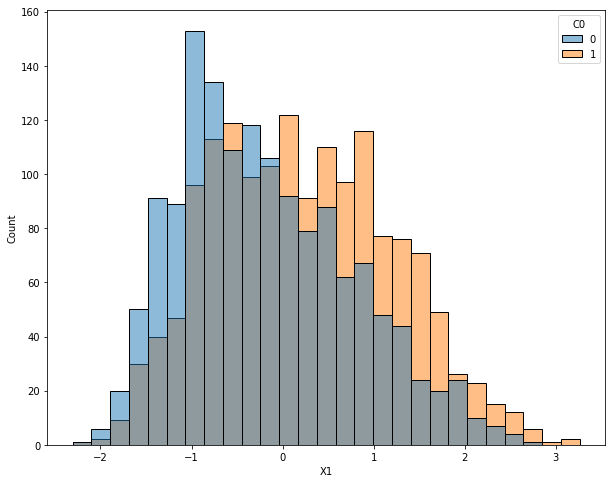

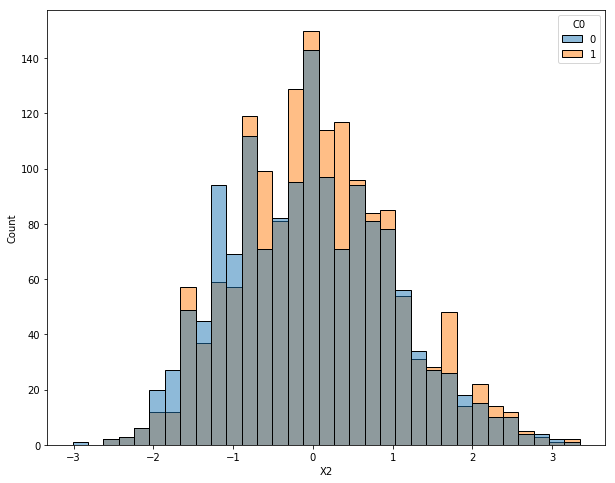

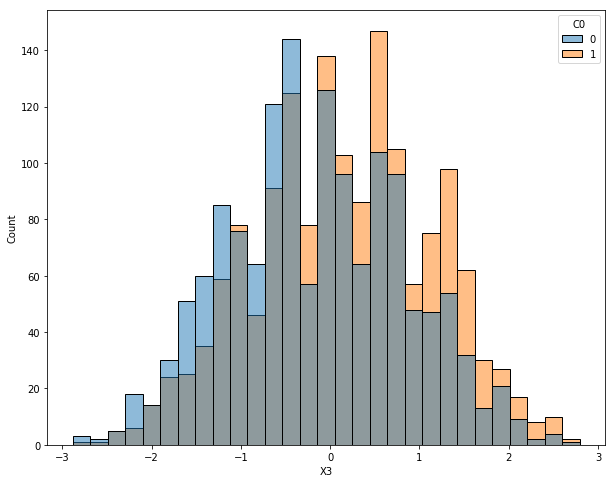

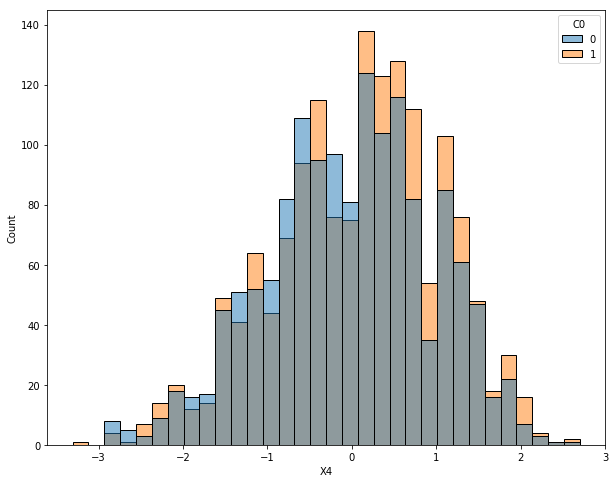

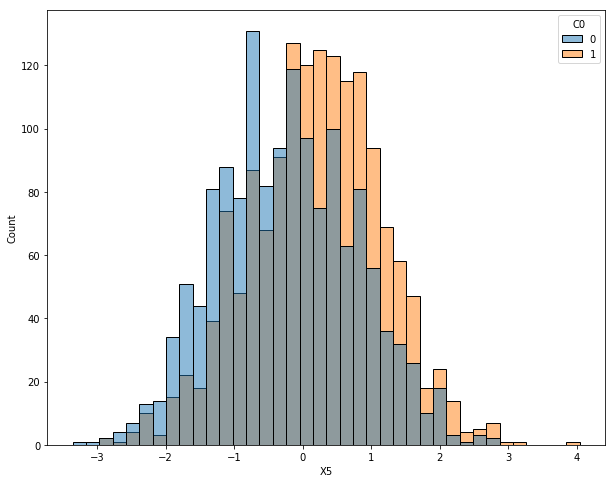

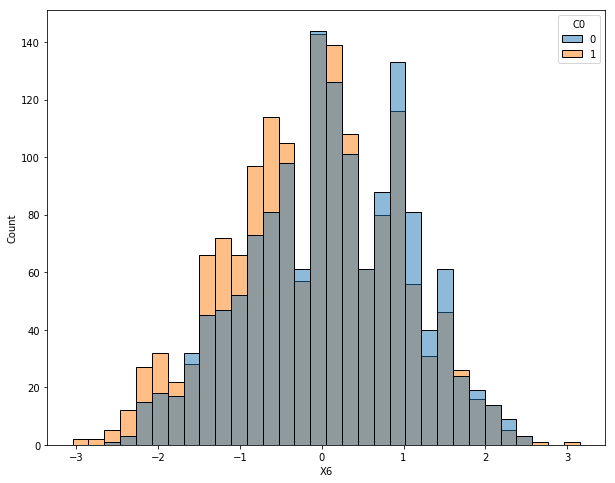

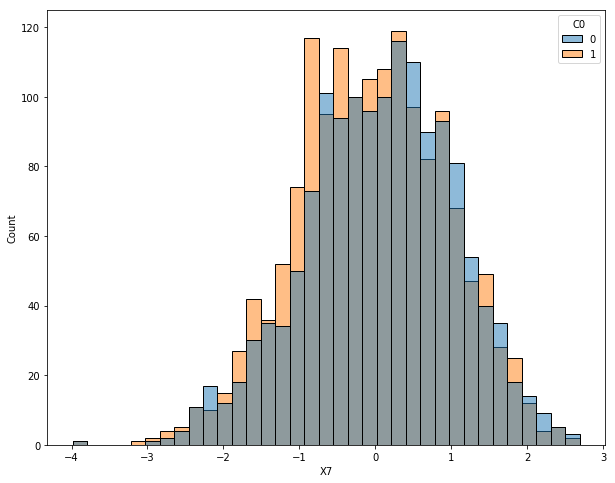

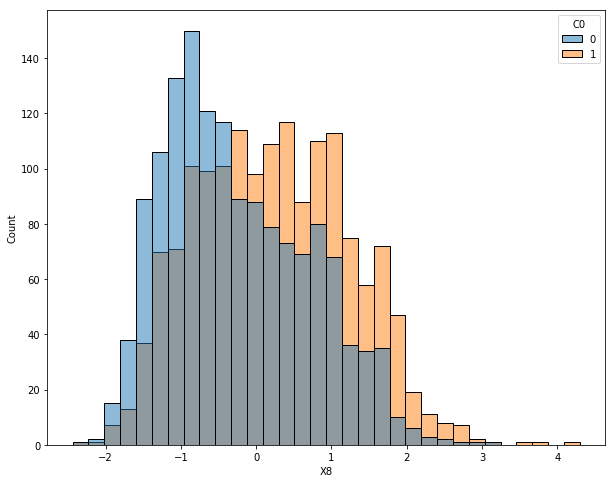

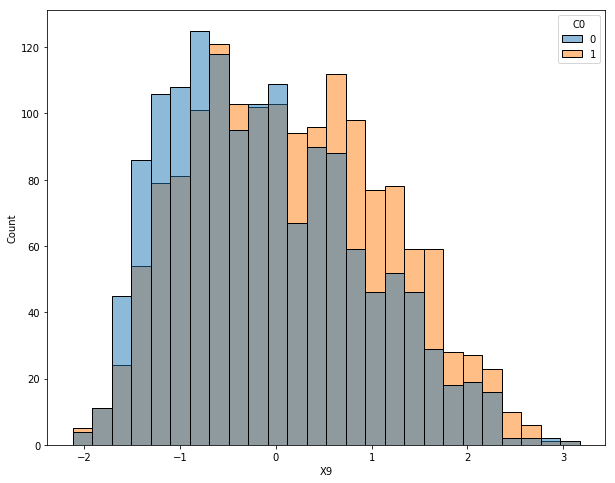

In [15]:
for n_num_atts in range(1, 10):
    ax = plt.figure(figsize=(10, 8))
    sns.histplot(x='X{}'.format(n_num_atts), data=dense_df, hue='C0')

In [24]:
dense_df['density'] = dense_df[['C0', 'Y', 'density_G0_L0', 'density_G0_L1', 'density_G1_L0', 'density_G1_L1']].apply(lambda x: combine_dense(x), axis=1)
dense_df['density_max'] = dense_df[['density_G0_L0', 'density_G0_L1', 'density_G1_L0', 'density_G1_L1']].apply(lambda x: get_maximum(x), axis=1)

In [25]:
dense_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,C0,density_G0_L0,density_G0_L1,density_G1_L0,density_G1_L1,density,density_max
0,0.403613,-0.760029,-1.495491,1.538432,0.982352,-0.282166,1.839695,1.326399,-0.551941,0,0,10.087788,-inf,-inf,-21.374224,10.087788,10.087788
1,-0.331060,-0.769690,-1.849364,-0.517347,-0.465138,-1.464779,-0.269203,-1.744422,-0.740582,0,1,-14.904341,-inf,9.793898,-18.735167,9.793898,9.793898
2,-1.050275,-1.268292,-0.105789,-1.800956,-1.332838,-1.694714,-0.865304,-0.898872,-1.467067,0,1,-inf,-inf,9.793898,-inf,9.793898,9.793898
3,1.569971,1.093808,-0.525895,0.110933,-0.441558,-0.666359,0.474688,1.783748,0.147531,0,0,10.087788,-inf,-inf,-inf,10.087788,10.087788
4,0.073097,0.800246,0.600790,0.403661,1.057387,-0.731163,0.246461,0.017919,-0.380416,0,1,-inf,-inf,9.793898,-inf,9.793898,9.793898


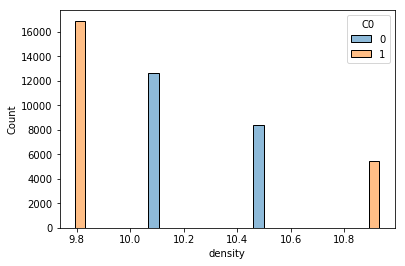

In [27]:
sns.histplot(x='density', data=dense_df, hue='C0')

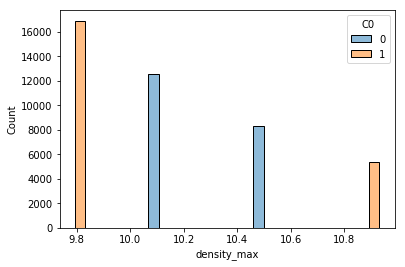

In [28]:
sns.histplot(x='density_max', data=dense_df, hue='C0')